# 1. Setup

## 1.1  Installing Necessary Libraries

In [ ]:
!pip install kaggle

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!echo '{"username":"ramaalyoubi","key":"82e22c4988257fba9141f3be474f0b66"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rashwan/arabic-chars-mnist
!unzip arabic-chars-mnist.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad5032.jpg       
  inflating: train/sad5033.jpg       
  inflating: train/sad5034.jpg       
  inflating: train/sad5035.jpg       
  inflating: train/sad5036.jpg       
  inflating: train/sad5037.jpg       
  inflating: train/sad5038.jpg       
  inflating: train/sad5039.jpg       
  inflating: train/sad5256.jpg       
  inflating: train/sad5257.jpg       
  inflating: train/sad5258.jpg       
  inflating: train/sad5259.jpg       
  inflating: train/sad5260.jpg       
  inflating: train/sad5261.jpg       
  inflating: train/sad5262.jpg       
  inflating: train/sad5263.jpg       
  inflating: train/sad5480.jpg       
  inflating: train/sad5481.jpg       
  inflating: train/sad5482.jpg       
  inflating: train/sad5483.jpg       
  inflating: train/sad5484.jpg       
  inflating: train/sad5485.jpg       
  inflating: train/sad5486.jpg       
  inflating: train/sad5487.jpg       
  inflating: train/sad552.jpg        

## 1.2 Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tensorflow.keras.utils import to_categorical
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# 2. Data Loading

In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    # Regular expression to extract non-digit characters at the beginning of the string
    label_regex = re.compile(r'^\D+')
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Check for image files
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                # Extract label using regex
                label_match = label_regex.match(filename)
                if label_match:
                    label = label_match.group()
                    labels.append(label)
                else:
                    print(f"Label not found in filename: {filename}")
    return np.array(images), labels  # Notice `labels` is a list, not a NumPy array

# 3. Data Preprocessing

## 3.1 Splitting and Cleaning

In [ ]:
train_images, train_labels = load_images_from_folder('/content/train')
test_images, test_labels = load_images_from_folder('/content/test')

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

num_classes = np.max(train_labels_encoded) + 1

# One-hot encoding of labels
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes)

## 3.2 EDA

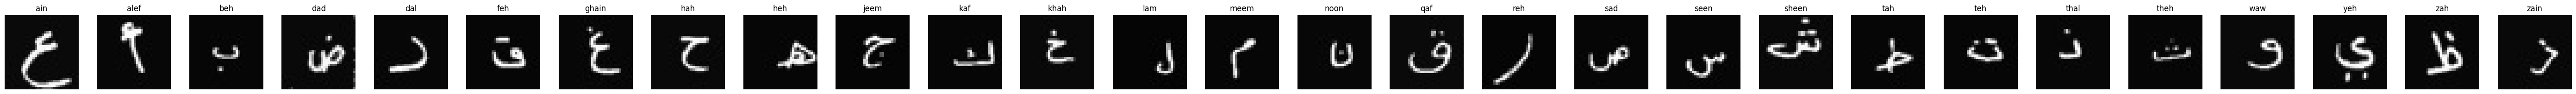

In [ ]:
def plot_images(images, labels, label_encoder):
    # Determine the number of unique classes
    num_classes = len(np.unique(labels))
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 2, 2))

    # For each unique class, find the first occurrence and plot it
    for i in range(num_classes):
        # Find the index of the first occurrence of each class
        class_idx = np.where(labels == i)[0][0]

        # Decode the label using label_encoder
        label = label_encoder.inverse_transform([i])[0]

        # Plot the image
        axes[i].imshow(images[class_idx].reshape(32, 32), cmap='gray')  # Adjust the shape to match your dataset
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot images for each class
plot_images(train_images, train_labels_encoded, label_encoder)

In [ ]:
print(f"Total data size: {len(train_images) + len(test_images)}")
print(f"Train set size: {len(train_images)}")
print(f"Test set size: {len(test_images)}")
print(f"Number of classes: {num_classes}")

Total data size: 16800
Train set size: 13440
Test set size: 3360
Number of classes: 28


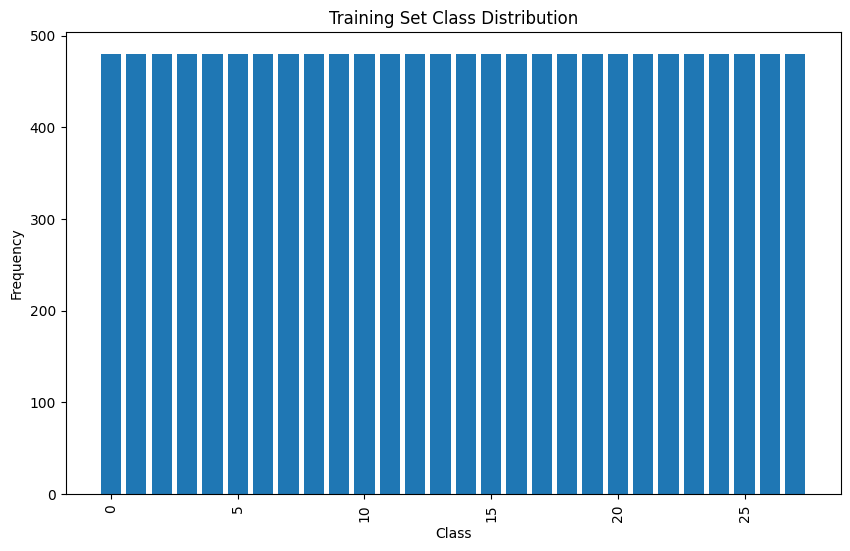

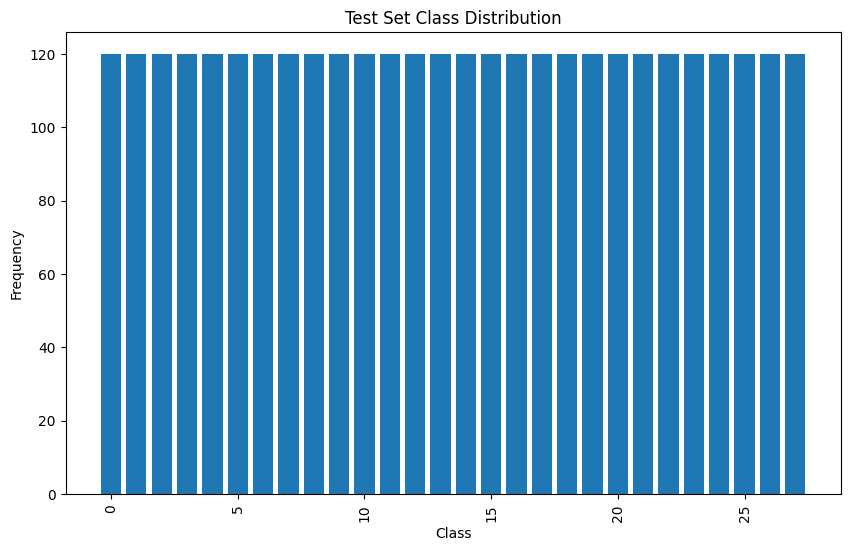

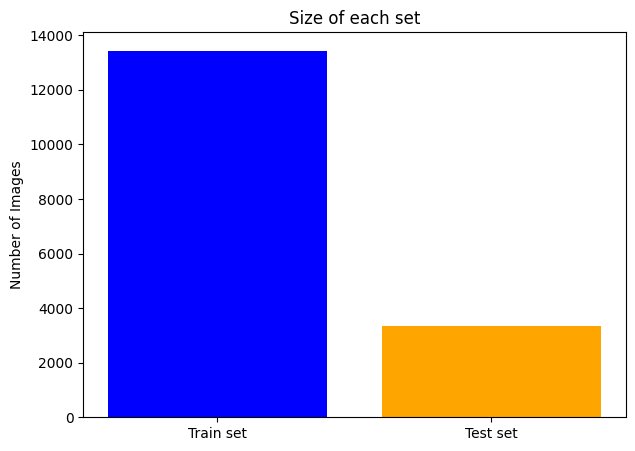

In [ ]:
def plot_class_distribution(labels, title):
    # Count the number of occurrences of each class
    counter = Counter(labels)
    # Sort the classes and their counts for consistent plotting
    sorted_classes = sorted(counter.items())
    classes, counts = zip(*sorted_classes)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=90)  # Rotate class labels for better visibility if needed
    plt.show()

def plot_set_sizes(train_set, test_set):
    # Plot the sizes of the training and test sets
    plt.figure(figsize=(7, 5))
    sets = ['Train set', 'Test set']
    sizes = [len(train_set), len(test_set)]

    plt.bar(sets, sizes, color=['blue', 'orange'])
    plt.ylabel('Number of Images')
    plt.title('Size of each set')
    plt.show()

# Plot class distribution in the training and test sets
plot_class_distribution(train_labels_encoded, 'Training Set Class Distribution')
plot_class_distribution(test_labels_encoded, 'Test Set Class Distribution')

# Plot sizes of the training and test sets
plot_set_sizes(train_images, test_images)


# 4. Model Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2

### CNN Model

In [ ]:
def create_advanced_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First conv layer
        Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),

        # Second conv layer
        Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),

        # Third conv layer
        Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),

        # Fourth conv layer
        Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),

        # Fifth conv layer
        Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),

        # Flattening the layers
        Flatten(),

        # Dense layers
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
input_shape = (32, 32, 1)
num_classes = 28
model = create_advanced_cnn_model(input_shape, num_classes)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 256)         0

In [ ]:
history = model.fit(
    train_images, train_labels_one_hot,
    epochs=20,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the data for validation
    verbose=1
)

Epoch 1/20
336/336 [==============================] - 12s 11ms/step - loss: 3.9375 - accuracy: 0.1667 - val_loss: 2.3484 - val_accuracy: 0.4714
Epoch 2/20
336/336 [==============================] - 4s 11ms/step - loss: 1.9556 - accuracy: 0.5714 - val_loss: 1.4337 - val_accuracy: 0.7199
Epoch 3/20
336/336 [==============================] - 4s 12ms/step - loss: 1.3098 - accuracy: 0.7693 - val_loss: 1.0653 - val_accuracy: 0.8371
Epoch 4/20
336/336 [==============================] - 4s 12ms/step - loss: 1.0307 - accuracy: 0.8424 - val_loss: 0.9318 - val_accuracy: 0.8564
Epoch 5/20
336/336 [==============================] - 4s 11ms/step - loss: 0.8395 - accuracy: 0.8905 - val_loss: 0.7761 - val_accuracy: 0.8906
Epoch 6/20
336/336 [==============================] - 3s 10ms/step - loss: 0.7288 - accuracy: 0.9114 - val_loss: 0.7363 - val_accuracy: 0.9074
Epoch 7/20
336/336 [==============================] - 4s 12ms/step - loss: 0.6567 - accuracy: 0.9254 - val_loss: 0.7999 - val_accuracy: 0.888

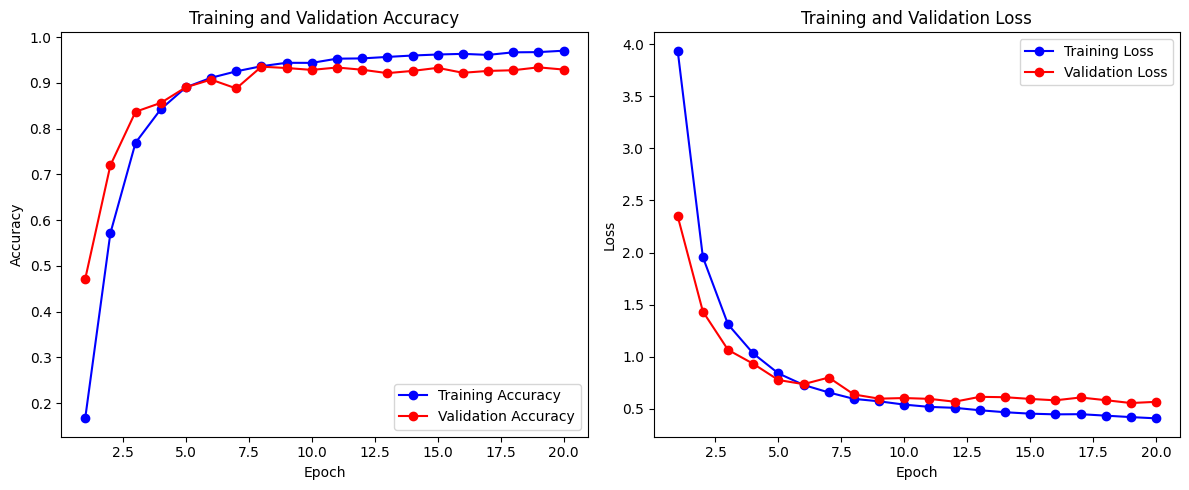

In [ ]:
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

105/105 [==============================] - 0s 4ms/step - loss: 0.5559 - accuracy: 0.9372
Test Loss: 0.5559284090995789
Test Accuracy: 0.9372023940086365


In [ ]:
from sklearn.metrics import classification_report

# Predict classes
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
test_labels_indices = np.argmax(test_labels_one_hot, axis=1)

# Print classification report
print(classification_report(test_labels_indices, predicted_classes))

105/105 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       120
           1       0.98      1.00      0.99       120
           2       0.98      1.00      0.99       120
           3       0.99      0.92      0.95       120
           4       0.96      0.88      0.92       120
           5       0.92      0.98      0.95       120
           6       0.97      0.96      0.96       120
           7       0.99      0.70      0.82       120
           8       0.96      0.93      0.94       120
           9       0.83      0.97      0.90       120
          10       0.97      0.97      0.97       120
          11       0.95      0.96      0.95       120
          12       0.98      0.99      0.99       120
          13       0.98      0.97      0.98       120
          14       0.91      0.88      0.89       120
          15       0.96      0.90      0.93       120
          16       0.92   

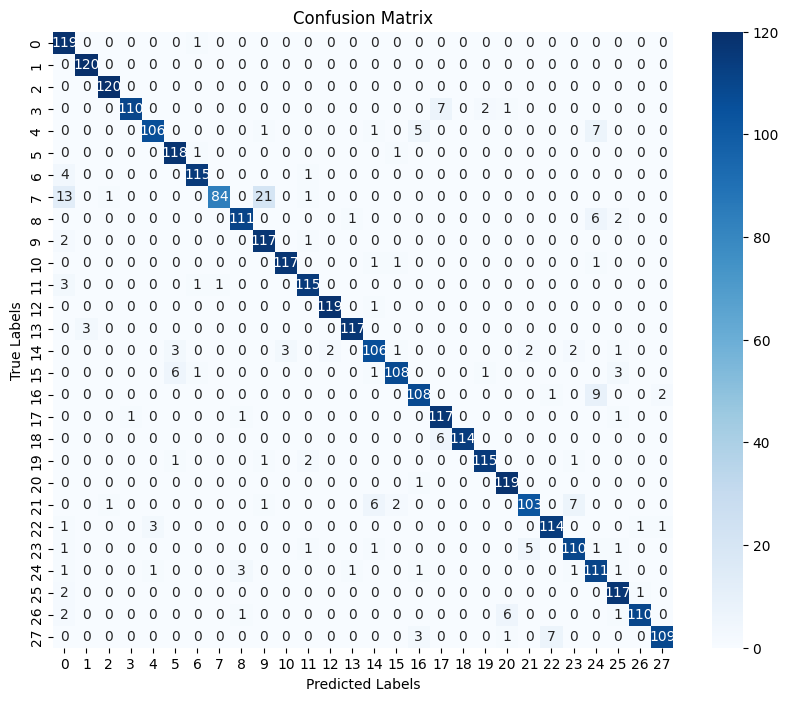

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels_encoded, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the function get_predictions to convert probabilities to actual labels
def get_predictions(pred, label_encoder):
    pred_indices = np.argmax(pred, axis=1)
    pred_labels = label_encoder.inverse_transform(pred_indices)
    return pred_labels

def display_images_with_labels_and_predictions(image_data, actual_labels, predictions, indices):
    num_columns = 4  # You can adjust this to change the number of images per row
    num_rows = len(indices) // num_columns + (len(indices) % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(4 * num_columns, 4 * num_rows))
    axs = axs.flatten()  # Flatten to easily use in a loop even if single row

    for i, ax in enumerate(axs):
        if i < len(indices):
            img_index = indices[i]
            ax.imshow(cv2.cvtColor(image_data[img_index], cv2.COLOR_BGR2RGB))
            ax.set_title(f"Actual: {actual_labels[img_index]}\nPredicted: {predictions[img_index]}")
            ax.axis('off')
        else:
            ax.axis('off')  # Hide any unused subplots

    plt.tight_layout()
    plt.show()

105/105 [==============================] - 0s 3ms/step


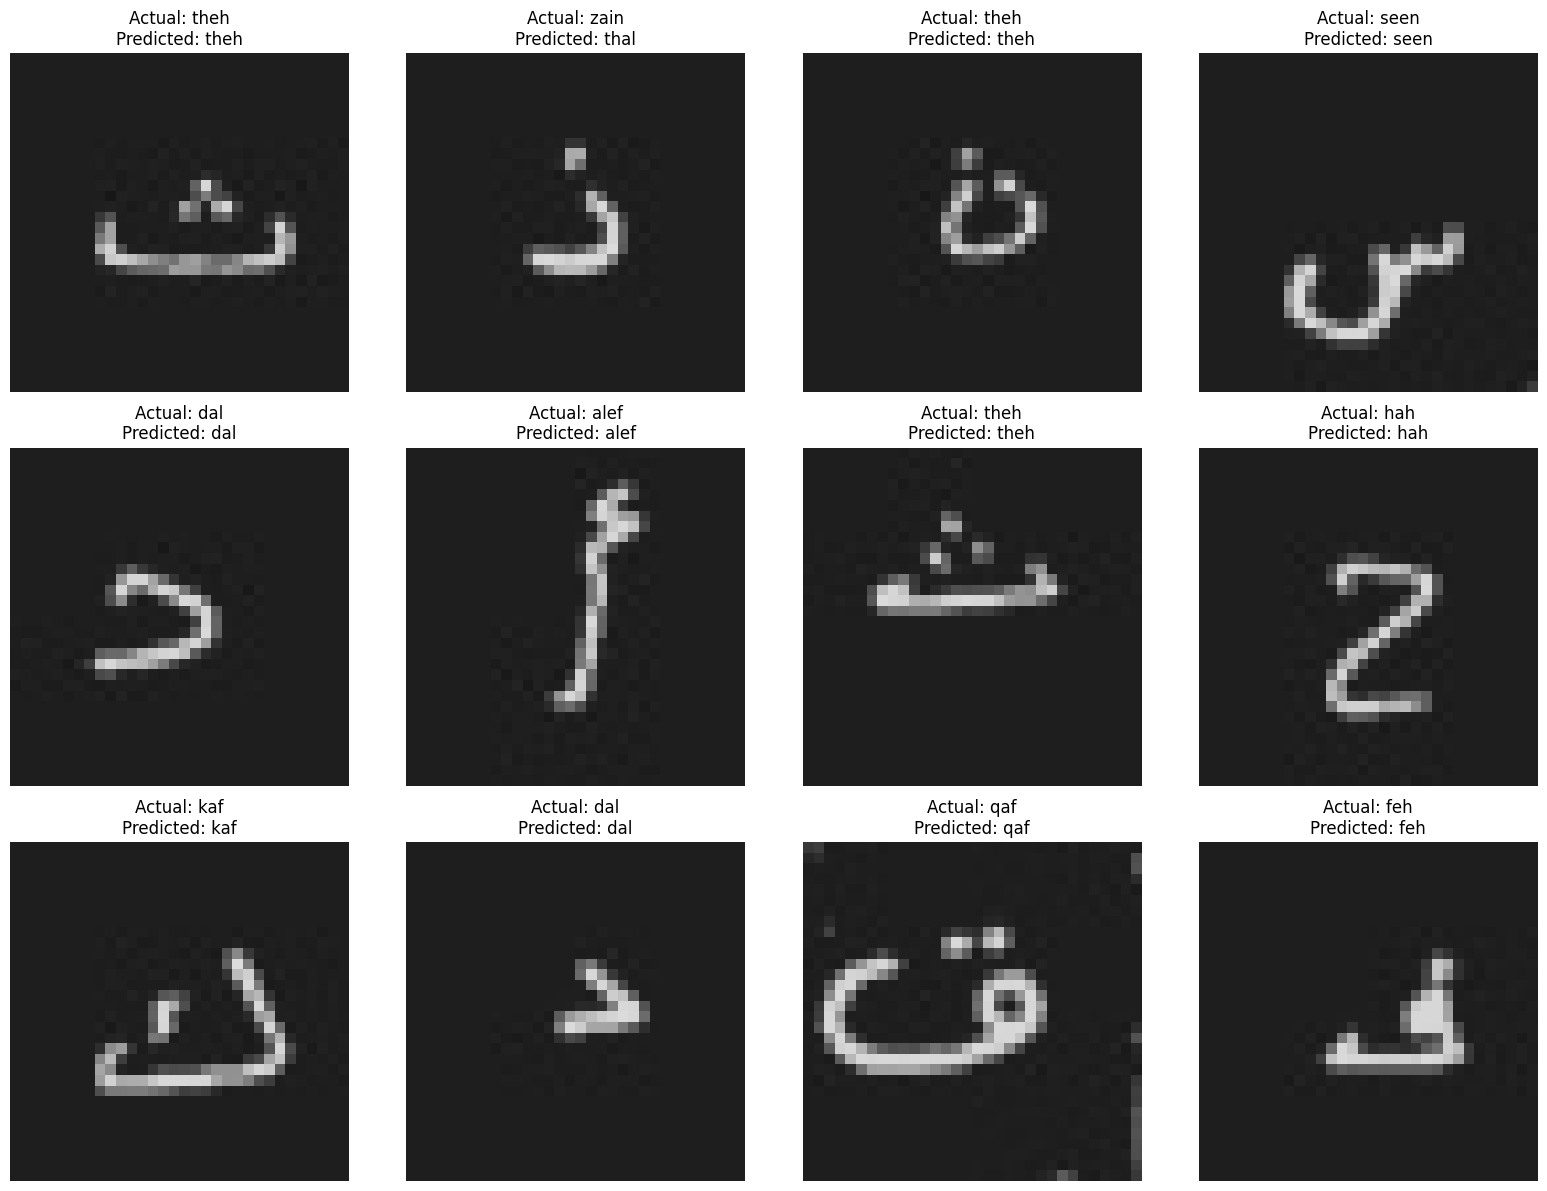

In [ ]:
import random

predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

actual_labels = test_labels

# Display images with their actual and predicted labels
num_samples = 12
max_index = len(test_images) - 1
sample_indices = random.sample(range(max_index + 1), num_samples)

Modelpredictions = get_predictions(predictions, label_encoder)
display_images_with_labels_and_predictions(test_images, actual_labels, Modelpredictions, sample_indices)


#### Results obtained for different variations of parameters of neural network both on validation and testing data.

### changing the convolution size and the kernel size and the L2 regulaizer
Convlution=64 and 32
kernel size= (3,3) and (6,6) and L2 Regulaizer=0.002

### CNN model 1 after some changes

In [ ]:
def create_advanced_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First conv layer
        Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.002)),
        MaxPooling2D(pool_size=(2, 2)),

        # Second conv layer
        Conv2D(32, kernel_size=(6, 6), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.002)),
        MaxPooling2D(pool_size=(2, 2)),

        # Third conv layer
        Conv2D(256, kernel_size=(6, 6), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.002)),
        MaxPooling2D(pool_size=(2, 2)),

        # Fourth conv layer
        Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.002)),
        MaxPooling2D(pool_size=(2, 2)),

        # Fifth conv layer
        Conv2D(32, kernel_size=(6, 6), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.002)),
        MaxPooling2D(pool_size=(2, 2)),

        # Flattening the layers
        Flatten(),

        # Dense layers
        Dense(512, activation='relu', kernel_regularizer=l2(0.002)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.002)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
input_shape = (32, 32, 1)
num_classes = 28
model = create_advanced_cnn_model(input_shape, num_classes)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        73760     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 4, 4, 256)        

In [ ]:
history = model.fit(
    train_images, train_labels_one_hot,
    epochs=20,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the data for validation
    verbose=1
)

Epoch 1/20
336/336 [==============================] - 6s 10ms/step - loss: 3.7567 - accuracy: 0.0484 - val_loss: 3.2730 - val_accuracy: 0.0666
Epoch 2/20
336/336 [==============================] - 3s 8ms/step - loss: 2.6273 - accuracy: 0.2286 - val_loss: 1.7924 - val_accuracy: 0.4821
Epoch 3/20
336/336 [==============================] - 2s 7ms/step - loss: 1.7165 - accuracy: 0.4936 - val_loss: 1.3547 - val_accuracy: 0.5993
Epoch 4/20
336/336 [==============================] - 2s 7ms/step - loss: 1.3704 - accuracy: 0.6164 - val_loss: 1.1346 - val_accuracy: 0.6830
Epoch 5/20
336/336 [==============================] - 2s 7ms/step - loss: 1.1876 - accuracy: 0.6746 - val_loss: 1.1258 - val_accuracy: 0.6897
Epoch 6/20
336/336 [==============================] - 2s 7ms/step - loss: 1.0667 - accuracy: 0.7199 - val_loss: 1.0285 - val_accuracy: 0.7314
Epoch 7/20
336/336 [==============================] - 3s 9ms/step - loss: 1.0178 - accuracy: 0.7439 - val_loss: 0.9313 - val_accuracy: 0.7798
Epoch

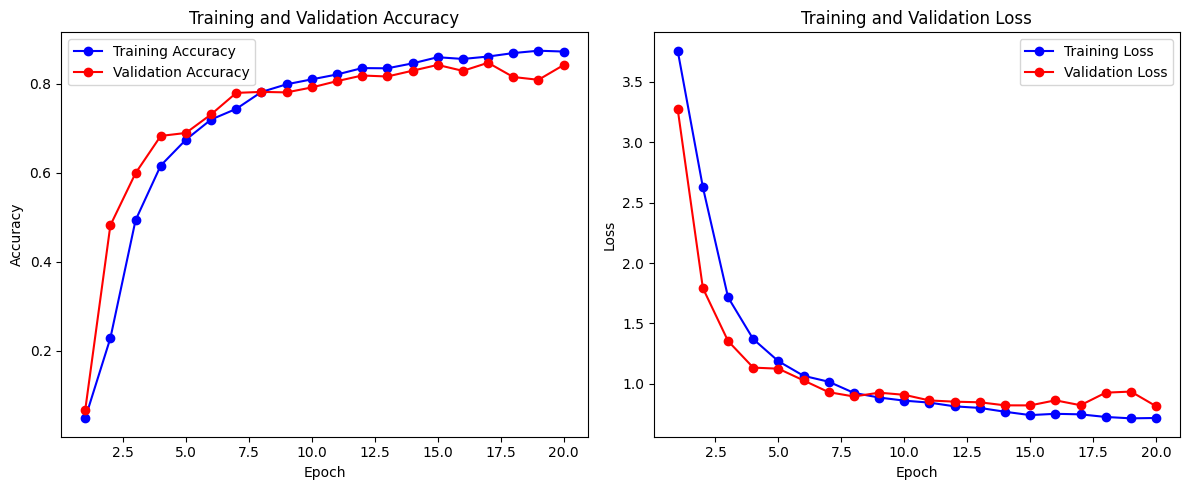

In [ ]:
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

105/105 [==============================] - 0s 4ms/step - loss: 0.8378 - accuracy: 0.8417
Test Loss: 0.8377987146377563
Test Accuracy: 0.8416666388511658


In [ ]:
# Predict classes
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
test_labels_indices = np.argmax(test_labels_one_hot, axis=1)

# Print classification report
print(classification_report(test_labels_indices, predicted_classes))

105/105 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       120
           1       0.94      1.00      0.97       120
           2       0.93      0.88      0.91       120
           3       0.81      0.85      0.83       120
           4       0.90      0.89      0.90       120
           5       0.77      0.67      0.71       120
           6       0.84      0.90      0.87       120
           7       0.72      0.84      0.77       120
           8       0.92      0.92      0.92       120
           9       0.69      0.79      0.74       120
          10       1.00      0.87      0.93       120
          11       0.86      0.82      0.84       120
          12       0.94      0.97      0.95       120
          13       0.97      0.91      0.94       120
          14       0.67      0.88      0.76       120
          15       0.70      0.82      0.75       120
          16       0.91   

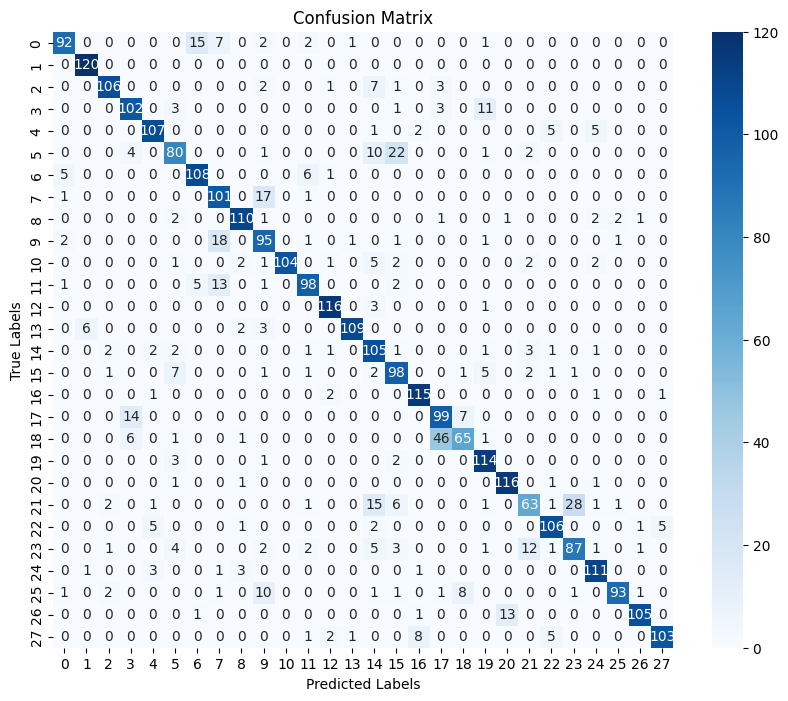

In [ ]:
cm = confusion_matrix(test_labels_encoded, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

105/105 [==============================] - 0s 3ms/step


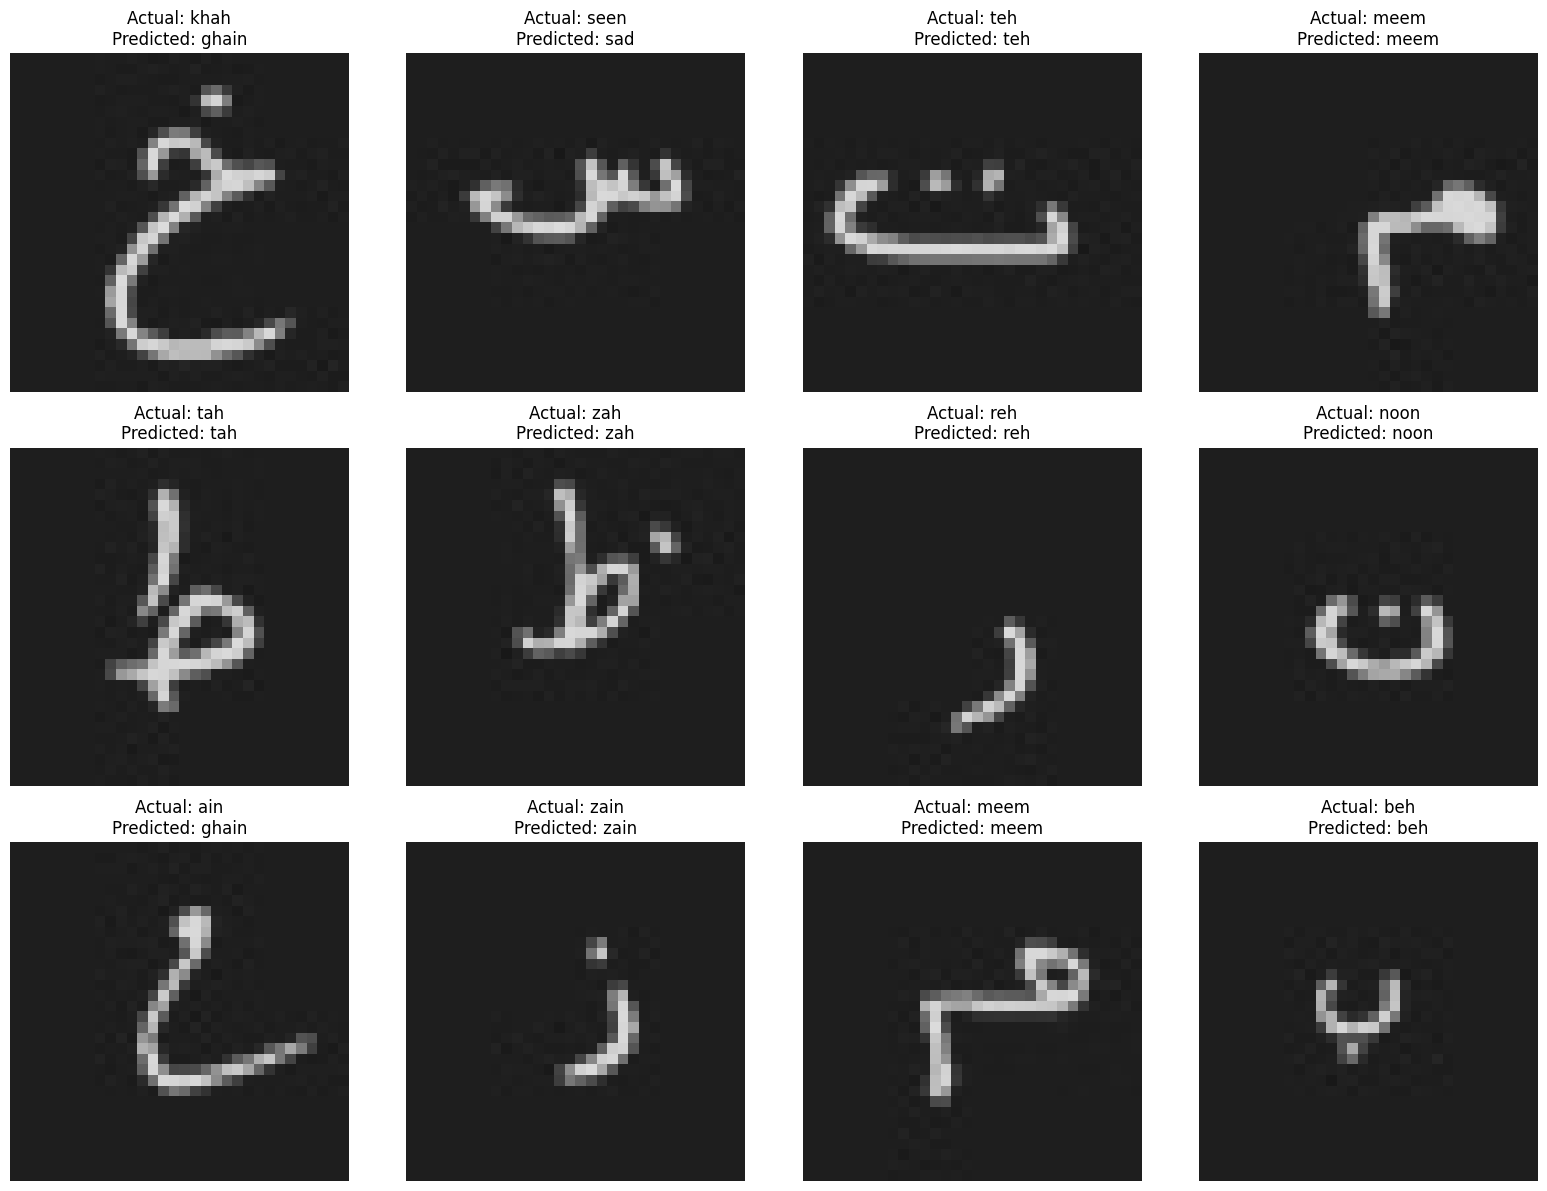

In [ ]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

actual_labels = test_labels

# Display images with their actual and predicted labels
num_samples = 12
max_index = len(test_images) - 1
sample_indices = random.sample(range(max_index + 1), num_samples)

Modelpredictions = get_predictions(predictions, label_encoder)
display_images_with_labels_and_predictions(test_images, actual_labels, Modelpredictions, sample_indices)

### CNN model 2 with some changes
### changing Covolution, kernel size, regularization, dense layer and Adding "Early Stopping"

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def create_advanced_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First conv layer
        Conv2D(128, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        # Second conv layer
        Conv2D(256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        # Third conv layer
        Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        # Fourth conv layer
        Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        # Fifth conv layer
        Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        # Flattening the layers
        Flatten(),

        # Dense layers
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Adding Early Stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    return model, early_stopping

In [ ]:
model, early_stopping = create_advanced_cnn_model(input_shape, num_classes)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 128)       3328      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 256)       819456    
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 8, 8, 256)         0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 8, 512)         1180160   
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 4, 4, 512)        

In [ ]:
history = model.fit(
    train_images, train_labels_one_hot,
    epochs=20,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the data for validation
    verbose=1
)

Epoch 1/20
336/336 [==============================] - 11s 22ms/step - loss: 10.4446 - accuracy: 0.0789 - val_loss: 4.3122 - val_accuracy: 0.1871
Epoch 2/20
336/336 [==============================] - 7s 22ms/step - loss: 3.2791 - accuracy: 0.2398 - val_loss: 2.3394 - val_accuracy: 0.4040
Epoch 3/20
336/336 [==============================] - 7s 22ms/step - loss: 2.1712 - accuracy: 0.4540 - val_loss: 1.7466 - val_accuracy: 0.5867
Epoch 4/20
336/336 [==============================] - 8s 22ms/step - loss: 1.7061 - accuracy: 0.6082 - val_loss: 1.4585 - val_accuracy: 0.6908
Epoch 5/20
336/336 [==============================] - 7s 22ms/step - loss: 1.4795 - accuracy: 0.6844 - val_loss: 1.2502 - val_accuracy: 0.7727
Epoch 6/20
336/336 [==============================] - 7s 21ms/step - loss: 1.3325 - accuracy: 0.7456 - val_loss: 1.1662 - val_accuracy: 0.7961
Epoch 7/20
336/336 [==============================] - 7s 21ms/step - loss: 1.2157 - accuracy: 0.7851 - val_loss: 1.0806 - val_accuracy: 0.83

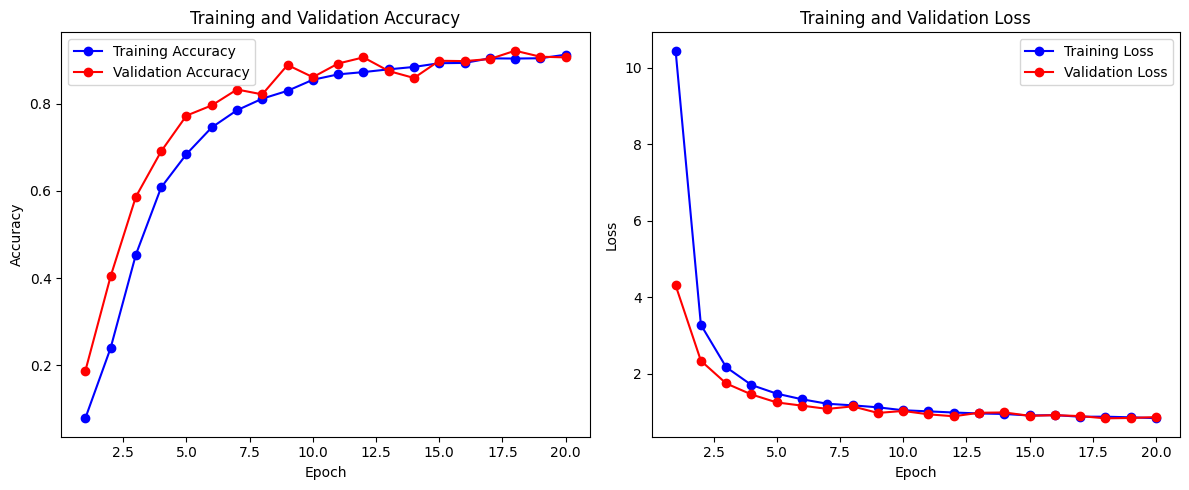

In [ ]:
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

105/105 [==============================] - 1s 7ms/step - loss: 0.8369 - accuracy: 0.9107
Test Loss: 0.8368542194366455
Test Accuracy: 0.9107142686843872


In [ ]:
# Predict classes
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
test_labels_indices = np.argmax(test_labels_one_hot, axis=1)

# Print classification report
print(classification_report(test_labels_indices, predicted_classes))

105/105 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       120
           1       0.99      0.97      0.98       120
           2       0.99      0.97      0.98       120
           3       0.93      0.93      0.93       120
           4       0.89      0.92      0.90       120
           5       0.72      0.86      0.78       120
           6       0.93      0.95      0.94       120
           7       0.86      0.94      0.90       120
           8       0.89      0.95      0.92       120
           9       0.99      0.90      0.94       120
          10       0.91      0.96      0.93       120
          11       0.96      0.94      0.95       120
          12       0.98      0.98      0.98       120
          13       0.97      0.97      0.97       120
          14       0.95      0.62      0.75       120
          15       0.85      0.82      0.84       120
          16       0.93   

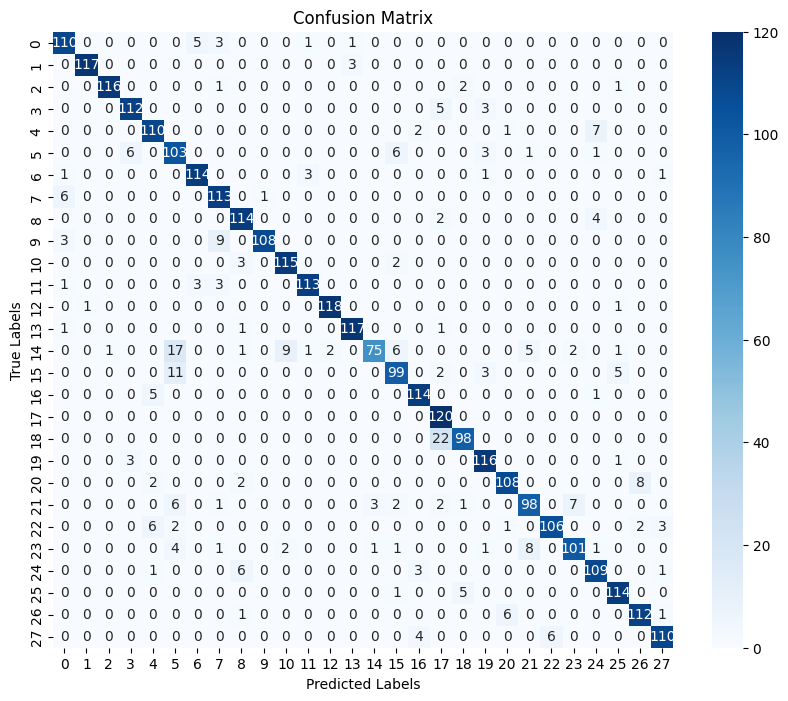

In [ ]:
cm = confusion_matrix(test_labels_encoded, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

105/105 [==============================] - 1s 6ms/step


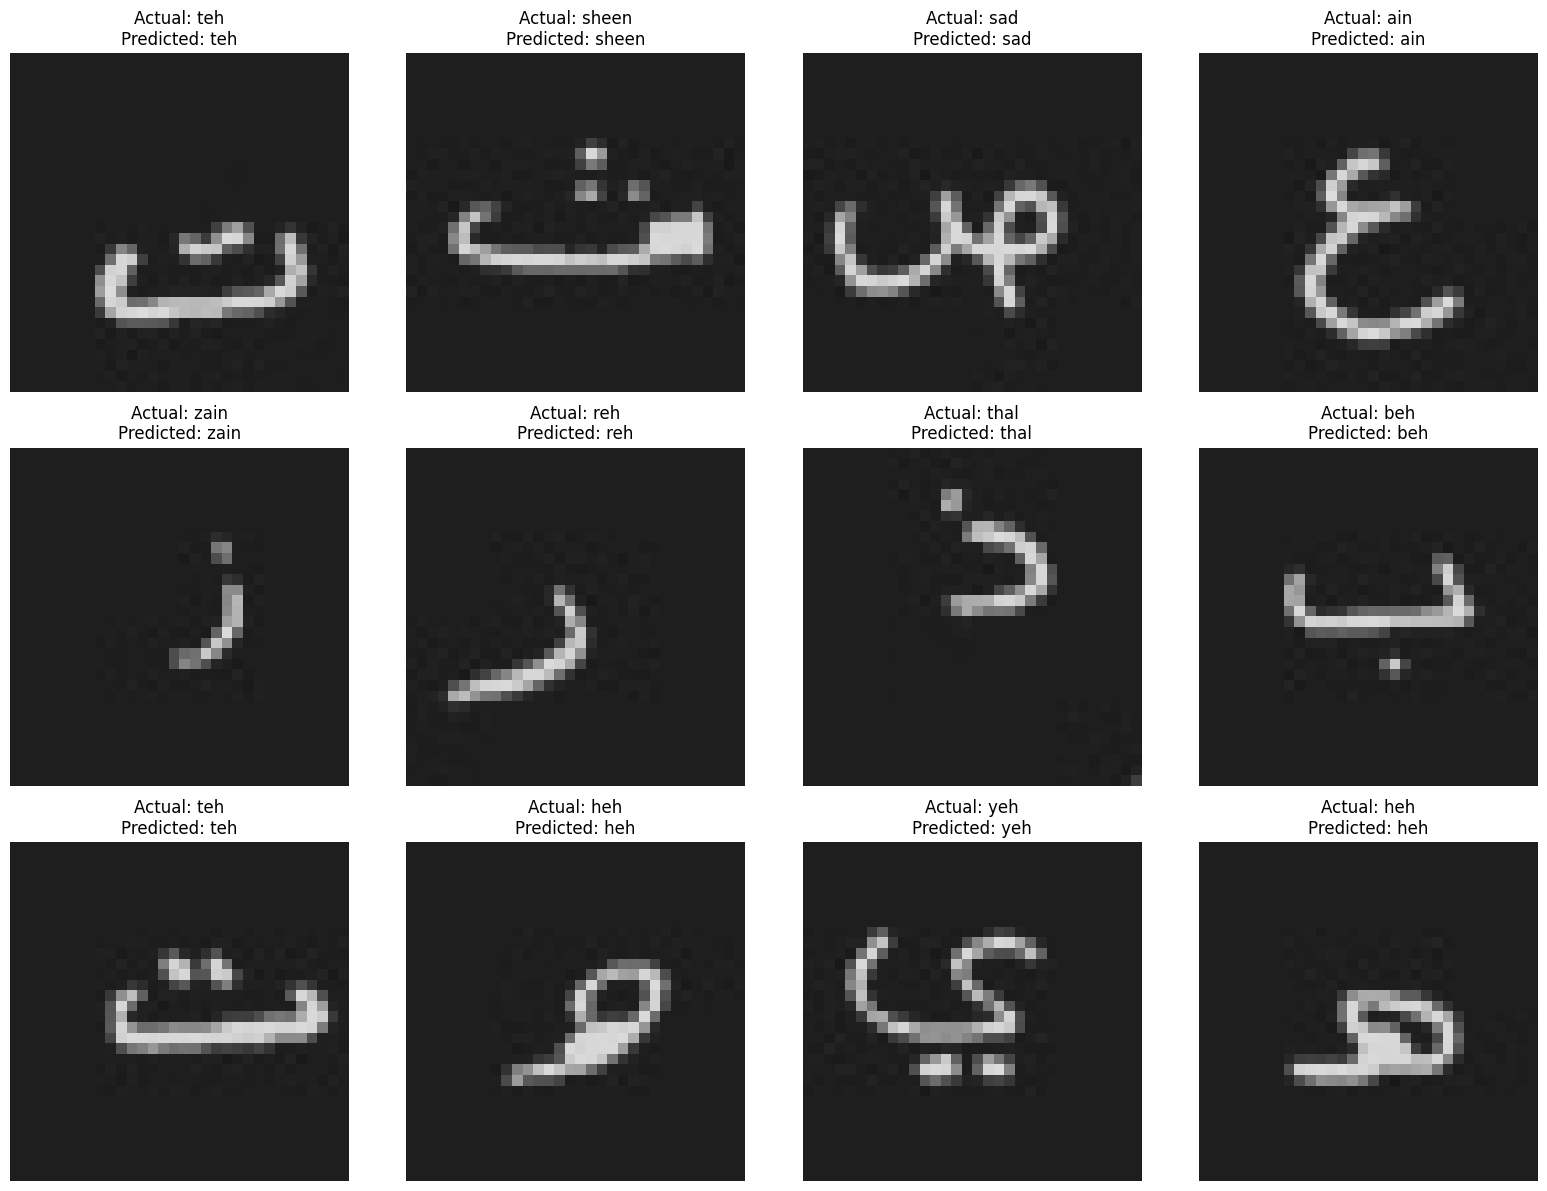

In [ ]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

actual_labels = test_labels

# Display images with their actual and predicted labels
num_samples = 12
max_index = len(test_images) - 1
sample_indices = random.sample(range(max_index + 1), num_samples)

Modelpredictions = get_predictions(predictions, label_encoder)
display_images_with_labels_and_predictions(test_images, actual_labels, Modelpredictions, sample_indices)

### CNN model 3 with some changes
### Applying Keras Tuner to the cnn model

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
from kerastuner import HyperModel, Hyperband

<ipython-input-56-75d6b2153abb>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, Hyperband


In [ ]:
def create_advanced_cnn_model(hp):
    model = Sequential()

    # Define hyperparameters
    hp_units = hp.Int('units', min_value=32, max_value=1024, step=32)
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # First conv layer
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second conv layer
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third conv layer
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth conv layer
    model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fifth conv layer
    model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening the layers
    model.add(Flatten())

    # Dense layers with hyperparameters
    model.add(Dense(units=hp_units, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(hp_dropout))
    model.add(Dense(units=hp_units//2, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(hp_dropout))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with the defined learning rate
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        return create_advanced_cnn_model(hp)

In [ ]:
hypermodel = CNNHyperModel(input_shape, num_classes)
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    directory='tuner_dir',
    project_name='cnn_hyperband'
)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels_one_hot, test_size=0.2, random_state=42)

In [ ]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Trial 30 Complete [00h 01m 25s]
val_accuracy: 0.9367559552192688

Best val_accuracy So Far: 0.9419642686843872
Total elapsed time: 00h 12m 37s


In [ ]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)
print('the best hyperparameter is: ', best_hyperparameters)
print('the best model is: ', best_model)

the best hyperparameter is:  <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7e7a807dec50>
the best model is:  <keras.src.engine.sequential.Sequential object at 0x7e7a8851be50>


In [ ]:
# Compile the best model
best_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the best model on the full training dataset
history = best_model.fit(train_images, train_labels_one_hot, epochs=10, validation_data=(test_images, test_labels_one_hot))

Epoch 1/10
420/420 [==============================] - 7s 12ms/step - loss: 3.1701 - accuracy: 0.3712 - val_loss: 1.6809 - val_accuracy: 0.6884
Epoch 2/10
420/420 [==============================] - 5s 12ms/step - loss: 1.2753 - accuracy: 0.7996 - val_loss: 0.9502 - val_accuracy: 0.8818
Epoch 3/10
420/420 [==============================] - 5s 12ms/step - loss: 0.8290 - accuracy: 0.8904 - val_loss: 0.7531 - val_accuracy: 0.8964
Epoch 4/10
420/420 [==============================] - 5s 11ms/step - loss: 0.6553 - accuracy: 0.9159 - val_loss: 0.6798 - val_accuracy: 0.9045
Epoch 5/10
420/420 [==============================] - 5s 12ms/step - loss: 0.5574 - accuracy: 0.9339 - val_loss: 0.5198 - val_accuracy: 0.9446
Epoch 6/10
420/420 [==============================] - 5s 12ms/step - loss: 0.4935 - accuracy: 0.9436 - val_loss: 0.5540 - val_accuracy: 0.9202
Epoch 7/10
420/420 [==============================] - 5s 11ms/step - loss: 0.4576 - accuracy: 0.9497 - val_loss: 0.4662 - val_accuracy: 0.9470

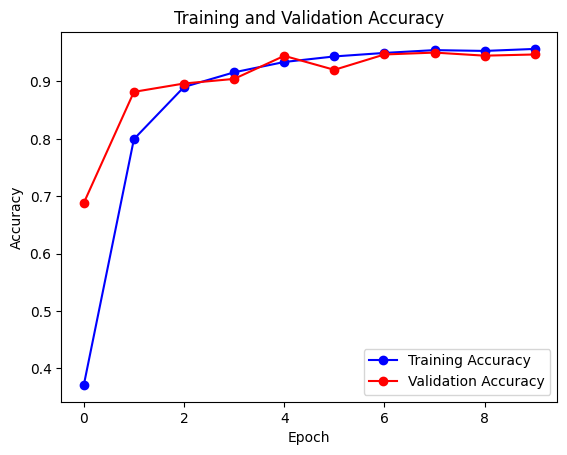

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.plot(train_accuracy,'bo-', label='Training Accuracy')
plt.plot(val_accuracy, 'ro-',label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels_one_hot)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

105/105 [==============================] - 0s 4ms/step - loss: 0.4414 - accuracy: 0.9470
Test Loss: 0.4414333403110504
Test Accuracy: 0.9470238089561462


In [ ]:
predictions = best_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
test_labels_indices = np.argmax(test_labels_one_hot, axis=1)

# Print classification report
print(classification_report(test_labels_indices, predicted_classes))

105/105 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       120
           1       0.92      1.00      0.96       120
           2       0.99      0.98      0.99       120
           3       0.98      0.94      0.96       120
           4       0.89      0.97      0.93       120
           5       0.93      0.89      0.91       120
           6       0.91      0.98      0.94       120
           7       0.97      0.96      0.96       120
           8       0.98      0.95      0.97       120
           9       0.98      0.98      0.98       120
          10       0.99      0.96      0.97       120
          11       1.00      0.90      0.95       120
          12       1.00      0.97      0.99       120
          13       0.99      0.97      0.98       120
          14       0.94      0.92      0.93       120
          15       0.88      0.95      0.92       120
          16       0.92   

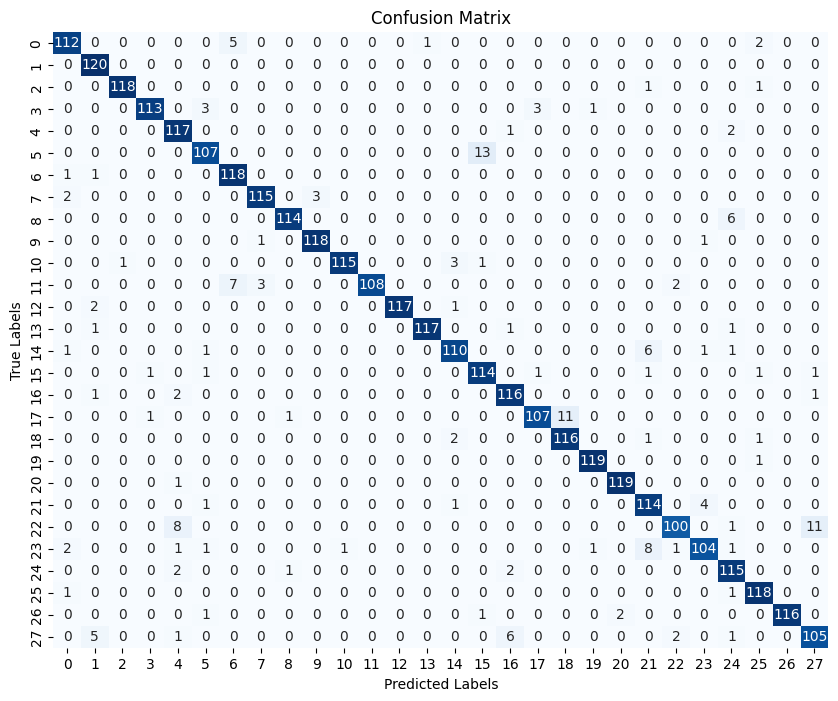

In [ ]:
conf_matrix = confusion_matrix(test_labels_indices, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


105/105 [==============================] - 1s 10ms/step


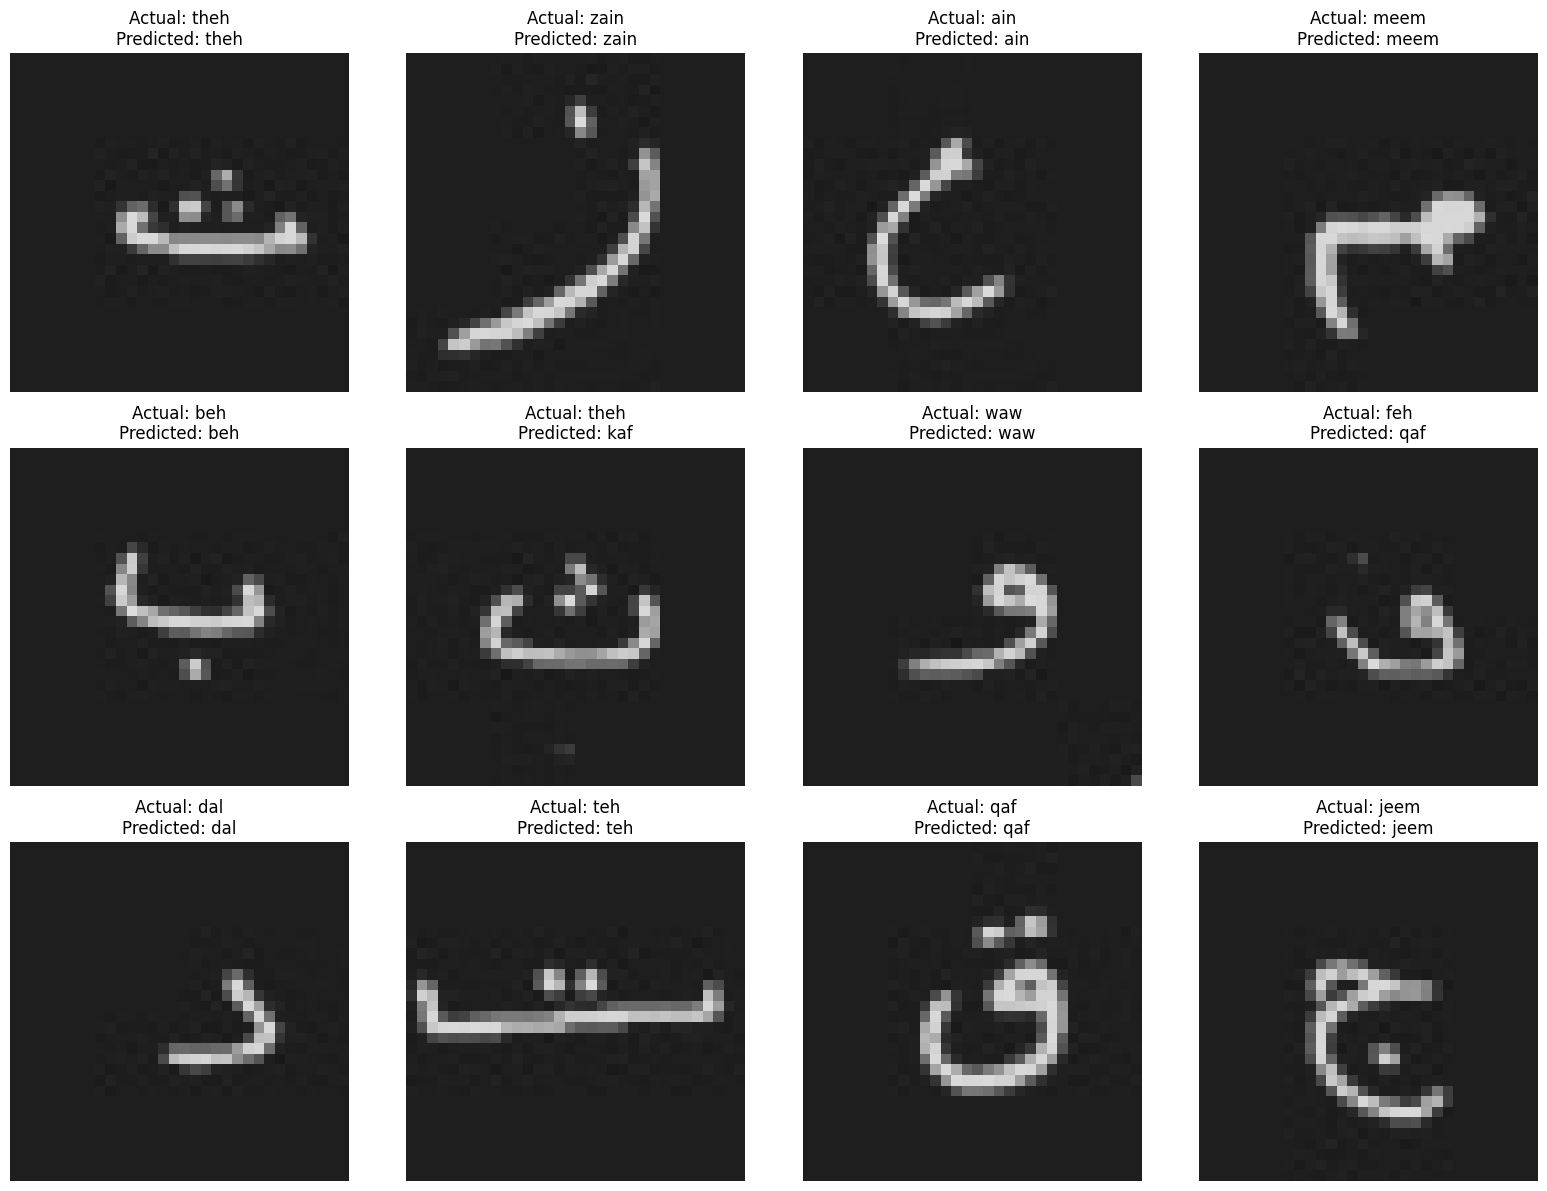

In [ ]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

actual_labels = test_labels

# Display images with their actual and predicted labels
num_samples = 12
max_index = len(test_images) - 1
sample_indices = random.sample(range(max_index + 1), num_samples)

Modelpredictions = get_predictions(predictions, label_encoder)
display_images_with_labels_and_predictions(test_images, actual_labels, Modelpredictions, sample_indices)

### The End